# Part 2 Preprocess
* * *

### Library import

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import  StandardScaler
import statsmodels.api as sm
from scipy import stats


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

InteractiveShell.ast_node_interactivity = "all"

### Loading data

Create a list of all files and add the corresponding city names and day type

In [2]:
data_paths = [("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekdays.csv", "Amsterdam", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekdays.csv", "Athens","Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekdays.csv", "Barcelona", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekdays.csv", "Berlin", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekdays.csv", "Budapest", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekdays.csv", "Lisbon", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekdays.csv", "London", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekdays.csv", "Rome", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekdays.csv", "Paris", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekdays.csv", "Vienna", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekends.csv", "Amsterdam", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekends.csv", "Athens", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekends.csv", "Barcelona", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekends.csv", "Berlin", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekends.csv", "Budapest", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekends.csv", "Lisbon", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekends.csv", "London", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekends.csv", "Rome", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekends.csv", "Paris", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekends.csv", "Vienna", "Weekends")]


Merge data from all csv into one data frame 

In [3]:
def load_data(data_paths):
    dfs = []
    for file_path, city_name, day_type in data_paths:
        df = pd.read_csv(file_path, usecols=lambda col: col != 'Unnamed: 0')
        df = df.assign(city=city_name, type=day_type)
        dfs.append(df)
    data = pd.concat(dfs)
    return data

data=load_data(data_paths)

### Basic Inspection of the dataset

Get information about the dataset

In [4]:
numeric_colums= ["realSum", "person_capacity","cleanliness_rating","guest_satisfaction_overall",'bedrooms', 'dist','metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat']
categorical_colums= ["room_type","room_shared", "room_private", "host_is_superhost","multi", "biz" , 'city', 'type']

Convert all categorical columns to objects

In [5]:
def format_features(data_t, categorical_colums):
    for i in categorical_colums:
        data_t[i] = data_t[i].astype('object')
        data_t[i].unique()
    return data_t
data=format_features(data,categorical_colums)

Create a lat and lng for each city

In [6]:
def add_lat_lng_percity(data_clean):
    for i in  ['Amsterdam','Athens','Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London', 'Paris', 'Rome','Vienna']:
        data_clean["lat_"+i]=0
        data_clean["lng_"+i]=0
    data_clean = data_clean.reset_index()
    for ind in data_clean.index:
        data_clean['lat_'+data_clean['city'][ind]][ind]=data_clean['lat'][ind]
        data_clean['lng_'+data_clean['city'][ind]][ind]=data_clean['lng'][ind]
    data_clean.drop(columns=['lng','lat'],inplace=True)
    return data_clean
data=add_lat_lng_percity(data)

/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_5900/2364620546.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['lat_'+data_clean['city'][ind]][ind]=data_clean['lat'][ind]
/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_5900/2364620546.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['lng_'+data_clean['city'][ind]][ind]=data_clean['lng'][ind]
/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_5900/2364620546.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

### Outlier analysis

For the outlier detection we will apply z-score method. First, separate the data for each city

In [7]:
cdf = data
print(cdf.count)
cities = cdf['city'].unique()

<bound method DataFrame.count of        index     realSum        room_type room_shared room_private   
0          0  194.033698     Private room       False         True  \
1          1  344.245776     Private room       False         True   
2          2  264.101422     Private room       False         True   
3          3  433.529398     Private room       False         True   
4          4  485.552926     Private room       False         True   
...      ...         ...              ...         ...          ...   
51702   1794  715.938574  Entire home/apt       False        False   
51703   1795  304.793960  Entire home/apt       False        False   
51704   1796  637.168969  Entire home/apt       False        False   
51705   1797  301.054157     Private room       False         True   
51706   1798  133.230489     Private room       False         True   

       person_capacity host_is_superhost multi biz  cleanliness_rating  ...   
0                  2.0             False     1 

Function for outlier detection

In [8]:
def detect_outliers_zscore(data, threshold=3):
    z_scores = (data - data.mean()) / data.std()  # Calculate the z-scores
    outliers = data[abs(z_scores) > threshold]  # Identify outliers using the specified threshold
    return outliers

Perform outlier detection and print outliers for each city

In [9]:
for city in cities:
    city_data = cdf[cdf['city'] == city]['realSum']  

    outliers = detect_outliers_zscore(city_data)
    
    if len(outliers) > 0:
        print(f"Detected outliers in {city}:")
        print(outliers)
    else:
        print(f"No outliers detected in {city}.")



Detected outliers in Amsterdam:
7        2771.307384
99       3004.944579
133      3637.663159
158      2556.183067
214      1997.281654
253      2500.878776
271      2458.228857
388      2061.959553
538      1892.531577
574      2058.210109
970      7782.907225
1056     1941.508682
1098     2486.115342
25504    2771.541724
25594    3005.413259
25629    3638.131840
25656    2556.886087
25691    1997.515994
25730    2501.113116
25741    2458.463197
25839    2062.662574
25905    2175.614557
25967    1892.765918
25993    2058.913130
26320    2199.985940
26359    8130.668104
26433    1941.977363
26471    2486.584023
Name: realSum, dtype: float64
Detected outliers in Athens:
2613     18545.450280
3743      1043.282638
28088     1043.282638
Name: realSum, dtype: float64
Detected outliers in Barcelona:
3942     1619.847790
4820     6943.700980
4821     6943.700980
5072     1620.080527
5104     4467.149208
5309     1770.661205
29261    1619.847790
29598    6086.298787
29605    2950.636535
2986

Perform the deletion of the found outliers

In [10]:
def remove_outliers(data, threshold=3):
    cities = data['city'].unique()
    for city in cities:
        city_data = data[data['city'] == city]['realSum']
        outliers = detect_outliers_zscore(city_data, threshold)
        if len(outliers) > 0:
            print(f"Detected outliers in {city}:")
            print(outliers)
            # Remove the outliers from the original dataset
            data = data.drop(outliers.index)
        else:
            print(f"No outliers detected in {city}.")
    return data

# Apply the remove_outliers function to the cdf dataset
cdf_clean = remove_outliers(cdf)
print('Number of deleted outliers: ', len(cdf)-len(cdf_clean))
    

Detected outliers in Amsterdam:
7        2771.307384
99       3004.944579
133      3637.663159
158      2556.183067
214      1997.281654
253      2500.878776
271      2458.228857
388      2061.959553
538      1892.531577
574      2058.210109
970      7782.907225
1056     1941.508682
1098     2486.115342
25504    2771.541724
25594    3005.413259
25629    3638.131840
25656    2556.886087
25691    1997.515994
25730    2501.113116
25741    2458.463197
25839    2062.662574
25905    2175.614557
25967    1892.765918
25993    2058.913130
26320    2199.985940
26359    8130.668104
26433    1941.977363
26471    2486.584023
Name: realSum, dtype: float64
Detected outliers in Athens:
2613     18545.450280
3743      1043.282638
28088     1043.282638
Name: realSum, dtype: float64
Detected outliers in Barcelona:
3942     1619.847790
4820     6943.700980
4821     6943.700980
5072     1620.080527
5104     4467.149208
5309     1770.661205
29261    1619.847790
29598    6086.298787
29605    2950.636535
2986

### Formating columns


In [11]:
numerical_colums=[ 'person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
 'bedrooms', 'dist', 'attr_index', 'rest_index','lat_Athens', 'lng_Athens','lat_Barcelona', 'lng_Barcelona', 'lat_Berlin', 'lng_Berlin',
 'lat_Budapest', 'lng_Budapest', 'lat_Lisbon', 'lng_Lisbon','lat_London', 'lng_London', 'lat_Paris', 'lng_Paris', 'lat_Rome','lng_Rome',
   'lat_Vienna', 'lng_Vienna', 'lat_Amsterdam','lng_Amsterdam']

Standarize data

In [12]:
for i in ["room_shared",	"room_private",	"host_is_superhost"]:
    cdf_clean[i].replace([False, True],[0,1],inplace=True)

One Hot encoding

In [13]:
for column in [ "city", "type"]:
    X_one_hot = pd.get_dummies(cdf_clean[column] , dtype=int, drop_first=False)
    cdf_clean = pd.concat([cdf_clean, X_one_hot], axis='columns')

# drop the values
cdf_clean= cdf_clean.drop(["room_type", "city", "type"], axis='columns')

Statistical Outlier Detection by columns 

In [14]:
import pandas as pd
from sklearn.ensemble import IsolationForest

prevdata=cdf_clean
# Assuming you have the 'prevdata' DataFrame
contamination = 0.10 
# Specify the columns on which you want to detect outliers
columns_to_check = prevdata.columns  # Replace with your actual column names

# Create a subset DataFrame with only the columns to check for outliers
subset_df = prevdata[columns_to_check]

# Create an IsolationForest model
isolation_forest = IsolationForest(contamination=contamination, random_state=42)

# Fit the IsolationForest model to the data
isolation_forest.fit(subset_df)

# Predict the outlier labels for each row
outlier_labels = isolation_forest.predict(subset_df)

# Filter the DataFrame to keep only non-outlier rows
filtered_df = prevdata[outlier_labels != -1]

filtered_df = filtered_df.reset_index()

/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, random_state=42)

Split data

In [15]:
filtered_df= filtered_df.drop(['level_0', 'index'], axis='columns')

In [16]:
X = filtered_df.loc[:,filtered_df.columns != 'realSum']
y = filtered_df['realSum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42
    ,stratify=X[[  'room_shared', 'room_private'  ]])

y_train_t= np.log(y_train + 0.000001)
y_test_t= np.log(y_test + 0.000001)


In [17]:
X_n = X_train
y_n = y_train


Identify features with multicollinearity

In [18]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Select the predictors (independent variables) for the regression model
predictors =  X_n.copy()
predictors.fillna(predictors.mean(), inplace=True)

# Calculate the VIF for each predictor
vif = pd.DataFrame()
vif['Predictor'] = predictors.columns
vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

# Identify predictors with high VIF (typically, VIF > 5 indicates multicollinearity)
high_vif_predictors = vif[vif['VIF'] > 7]['Predictor']

# Remove highly correlated predictors from the dataset
filtered_data = predictors.drop(high_vif_predictors, axis=1)

# Print the remaining predictors without multicollinearity
print("Remaining predictors without multicollinearity:")
print(filtered_data.columns)


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Remaining predictors without multicollinearity:
Index(['room_shared', 'room_private', 'person_capacity', 'host_is_superhost',
       'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'lng_London'],
      dtype='object')


### Selection feature

Selection feature based on correlation

In [19]:
X_n_temp= X_n.copy()
X_n_temp["realSum"]=np.log(y_n + 0.000001)
# Calculate correlations with the target variable
correlations = X_n_temp.corr()['realSum'].abs().sort_values(ascending=False)

# Select the top correlated features (e.g., top 5)
top_features = correlations[1:len(X_n_temp.columns)].index

# Subset the DataFrame with selected features
selected_data = X_n_temp[top_features]

Selection feature based on KBest

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression

#Selecting the Best important features according to Logistic Regression
sfs_selector = SelectKBest(score_func=f_regression)
sfs_selector.fit(X_n,y_train_t)
selected_feature_names = X_n.columns[sfs_selector.get_support(indices=True)]
feature_scores = zip(selected_feature_names, sfs_selector.scores_[sfs_selector.get_support(indices=True)])
for feature, score in feature_scores:
    print(f"{feature}: {score}")
print(" ")


SelectKBest(score_func=<function f_regression at 0x128e19940>)

room_private: 3926.3402666344787
person_capacity: 3139.944971515661
attr_index: 3631.517916652002
attr_index_norm: 9374.279166980004
lat_Athens: 3350.6448441296025
lng_Athens: 3350.3377144852725
lat_Paris: 3715.7357941510563
lng_Paris: 3686.978177088297
Athens: 3349.9497960901463
Paris: 3715.9622386995134
 


Cross Validation Feature selection

In [47]:
def modelfit(alg, dtrain, ytrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, ytrain, cv=cv_folds, scoring='neg_mean_absolute_error')
    
    #Print model report:
    print ("\nModel Report")
    print( "Mean absolute error : %.4g" % metrics.mean_absolute_error(ytrain, dtrain_predictions))


    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        print( pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False))
        

GradientBoostingRegressor(random_state=0)


Model Report
Mean absolute error : 0.2209
CV Score : Mean - -0.2236819 | Std - 0.00143502 | Min - -0.2256746 | Max - -0.221256
attr_index_norm               0.297103
room_private                  0.140494
bedrooms                      0.071577
person_capacity               0.068698
lng_Athens                    0.064760
lat_Budapest                  0.046407
lat_Athens                    0.040144
lat_Paris                     0.036545
lng_Budapest                  0.024601
lat_London                    0.022973
lng_London                    0.022773
lng_Rome                      0.018236
Amsterdam                     0.018134
lng_Amsterdam                 0.017864
room_shared                   0.014200
Budapest                      0.011918
lng_Paris                     0.010341
guest_satisfaction_overall    0.009650
cleanliness_rating            0.009074
rest_index                    0.009071
lat_Amsterdam                 0.008624
lat_Rome                      0.006786
biz           

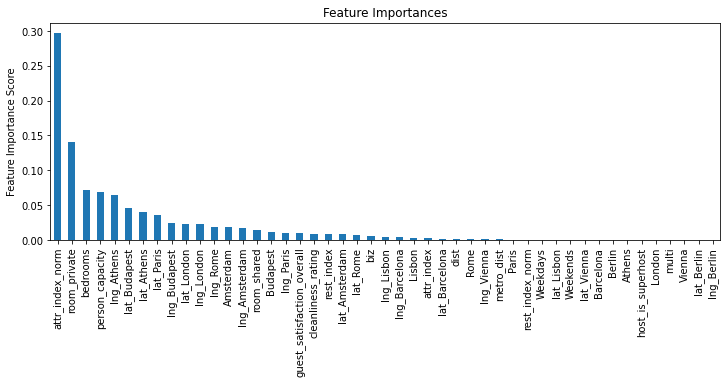

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

predictors =X_n.columns

model = GradientBoostingRegressor(random_state=0)
model.fit(X_n,y_train_t)

modelfit(model, X_n,y_train_t, predictors)

New variables according to feature selection

In [20]:
new_variables=['attr_index_norm' ,'room_private','bedrooms' ,'person_capacity','lng_Athens',
'lat_Budapest','lat_Athens','lat_Paris' ,'lng_Budapest','lat_London','lng_London','lng_Rome',                      
'Amsterdam','lng_Amsterdam','room_shared','Budapest','lng_Paris','guest_satisfaction_overall',
'cleanliness_rating','rest_index','lat_Amsterdam','lat_Rome','biz','lng_Lisbon','lng_Barcelona',                 
'Lisbon','lat_Barcelona','dist','Rome','lng_Vienna' ,'metro_dist','Paris']

### Analysis Skewness features

In [21]:
temp_right_columns= []
temp_left_columns=[]

for i in X_n.columns:
    variable = X_n[i]

    # Calculate the skewness of the variable
    skewness = variable.skew()

    # Interpret the skewness value
    if skewness > 0:
        temp_right_columns.append(i)
    elif skewness < 0:
        temp_left_columns.append(i)
    else:
        print("The variable is approximately symmetric (no skew).")

In [22]:
print(temp_right_columns)
print(temp_left_columns)
temp_right_columns=[ 'room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm']
temp_left_columns=[ 'cleanliness_rating', 'guest_satisfaction_overall']

right_columns=[]
left_columns=[]

for i in new_variables:
    if(i in temp_right_columns):
        right_columns.append(i)
    if(i in temp_left_columns):
        left_columns.append(i)


['room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lat_Amsterdam', 'lng_Amsterdam', 'lat_Athens', 'lng_Athens', 'lat_Barcelona', 'lng_Barcelona', 'lat_Berlin', 'lng_Berlin', 'lat_Budapest', 'lng_Budapest', 'lat_Lisbon', 'lat_London', 'lat_Paris', 'lng_Paris', 'lat_Rome', 'lng_Rome', 'lat_Vienna', 'lng_Vienna', 'Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London', 'Paris', 'Rome', 'Vienna', 'Weekdays']
['cleanliness_rating', 'guest_satisfaction_overall', 'lng_Lisbon', 'lng_London', 'Weekends']


Data transformation based on the distribution 

In [23]:
def categorical_preprocessing(X, y,scaler=None):
    print('Original shape:{}'.format(X.shape))
    X[right_columns]=np.log( X[right_columns] + 0.000001)
    X[left_columns]=np.power(X[left_columns],3)
    print('New shape:{}'.format(X.shape))
    return X, y, scaler


In [24]:
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

Original shape:(32309, 47)
New shape:(32309, 47)
Original shape:(13848, 47)
New shape:(13848, 47)


Select features based on feature selection

In [33]:
X_train=X_n[new_variables]
X_test=X_test[new_variables]

Models

In [34]:
results_models=[]

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight

sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

#lr_one_hot = GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, random_state=0)
model = GradientBoostingRegressor(random_state=0)

y_train_t= np.log(y_train + 0.000001)
y_test_t= np.log(y_test + 0.000001)

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train_t, cv=10, scoring='neg_mean_absolute_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train_t, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train_t)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test_t, y_pred)
r2 = r2_score(y_test_t, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)


# Predict on the test set and calculate metrics
y_pred =np.exp(y_pred) - 0.000001 
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absoute error on test set: ", msa)
print("R2 score on test set: ", r2)

results_models.append(["Gradient Boosting Regressor",msa,r2])

Mean squared error using cross-validation:  0.22333989850565458
R2 score using cross-validation:  0.713021245364723


GradientBoostingRegressor(random_state=0)

Mean squared error on test set:  0.22490557278930381
R2 score on test set:  0.7024755224909525
Mean absoute error on test set:  57.57171576561869
R2 score on test set:  0.6350036166155248


In [36]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train_t, cv=10, scoring='neg_mean_absolute_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train_t, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train_t, sample_weight=sample_weights_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test_t, y_pred)
r2 = r2_score(y_test_t, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)


# Predict on the test set and calculate metrics
y_pred =np.exp(y_pred) - 0.000001 
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absolute error on test set: ", msa)
print("R2 score on test set: ", r2)

results_models.append(["Linear Regression",msa,r2])

Mean squared error using cross-validation:  0.2437095284755026
R2 score using cross-validation:  0.6629259871780621


LinearRegression()

Mean squared error on test set:  0.2686361458354227
R2 score on test set:  0.6066345808405099
Mean absolute error on test set:  68.25389923873384
R2 score on test set:  0.5927032430703032


In [37]:
from sklearn.linear_model import RidgeCV

model =  RidgeCV()

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train_t, cv=10, scoring='neg_mean_absolute_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train_t, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train_t, sample_weight=sample_weights_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test_t, y_pred)
r2 = r2_score(y_test_t, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)


# Predict on the test set and calculate metrics
y_pred =np.exp(y_pred) - 0.000001 
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absolute error on test set: ", msa)
print("R2 score on test set: ", r2)

results_models.append(["Ridge",msa,r2])

Mean squared error using cross-validation:  0.4137969271928319
R2 score using cross-validation:  -0.0514789018374759


RidgeCV()

Mean squared error on test set:  0.8322736689309721
R2 score on test set:  -2.808102807859444
Mean absolute error on test set:  229.22500051378498
R2 score on test set:  -3.0744923039166645


In [38]:
from sklearn.linear_model import LassoCV

model =  LassoCV()

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train_t, cv=10, scoring='neg_mean_absolute_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train_t, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train_t, sample_weight=sample_weights_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test_t, y_pred)
r2 = r2_score(y_test_t, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)


# Predict on the test set and calculate metrics
y_pred =np.exp(y_pred) - 0.000001 
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absolute error on test set: ", msa)
print("R2 score on test set: ", r2)

results_models.append(["Lasso",msa,r2])

Mean squared error using cross-validation:  0.3797807711421898
R2 score using cross-validation:  0.21899672711791357


LassoCV()

Mean squared error on test set:  0.4208000724282327
R2 score on test set:  0.0789658199585428
Mean absolute error on test set:  103.43035867903856
R2 score on test set:  0.20826360107667652


Results Models

In [39]:
final_results=pd.DataFrame(results_models, columns=["Model Name","MSA", "R2"])
final_results

,Model Name,MSA,R2
0,Gradient Boosting Regressor,57.571716,0.635004
1,Linear Regression,68.253899,0.592703
2,Ridge,229.225001,-3.074492
3,Lasso,103.430359,0.208264


Tunning parameters in the best model

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

y_train_t= np.log(y_train + 0.000001)
y_test_t= np.log(y_test + 0.000001)

sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train_t)

# Create the GradientBoostingRegressor model
model = GradientBoostingRegressor(random_state=0)

# Define the parameter grid to search
param_grid = {
    'loss': ['huber', 'ls', 'lad'],  # example values for loss function
    'alpha': [0.9, 0.95, 1.0],       # example values for alpha
    'n_estimators': [100, 200, 300]  # example values for the number of estimators
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_absolute_error'
)
grid_search.fit(X_train, y_train_t)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Train the model on the full training set using the best parameters
best_model.fit(X_train, y_train_t)

# Predict on the test set and calculate metrics
y_pred = best_model.predict(X_test)
mse = mean_absolute_error(y_test_t, y_pred)
r2 = r2_score(y_test_t, y_pred)
print("Mean absolute error on test set: ", mse)
print("R2 score on test set: ", r2)

# Predict on the test set and calculate metrics
y_pred = np.exp(y_pred) - 0.000001
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean absolute error on test set: ", msa)
print("R2 score on test set: ", r2)


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
210 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/base.py", line 570,

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'alpha': [0.9, 0.95, 1.0],
                         'loss': ['huber', 'ls', 'lad'],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error')

Best Parameters:
alpha: 0.9
loss: huber
n_estimators: 300


GradientBoostingRegressor(loss='huber', n_estimators=300, random_state=0)

Mean absolute error on test set:  0.21302419043694332
R2 score on test set:  0.7279234668022403
Mean absolute error on test set:  54.8388234037504
R2 score on test set:  0.6613277738778303


Graphs of the Result Data

Amsterdam
 Weekdays: 9.91%
 Weekends: 9.91%
Athens
 Weekdays: 34.64%
 Weekends: 34.64%
Barcelona
 Weekdays: 18.72%
 Weekends: 18.72%
Berlin
 Weekdays: 22.48%
 Weekends: 22.48%
Budapest
 Weekdays: 32.06%
 Weekends: 32.06%
Lisbon
 Weekdays: 22.85%
 Weekends: 22.85%
London
 Weekdays: 14.99%
 Weekends: 14.99%
Paris
 Weekdays: 13.54%
 Weekends: 13.54%
Rome
 Weekdays: 26.78%
 Weekends: 26.78%
Vienna
 Weekdays: 22.46%
 Weekends: 22.46%


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

[Text(0.175, 0, 'Amsterdam'),
 Text(1.175, 0, 'Athens'),
 Text(2.175, 0, 'Barcelona'),
 Text(3.175, 0, 'Berlin'),
 Text(4.175, 0, 'Budapest'),
 Text(5.175, 0, 'Lisbon'),
 Text(6.175, 0, 'London'),
 Text(7.175, 0, 'Paris'),
 Text(8.175, 0, 'Rome'),
 Text(9.175, 0, 'Vienna')]

Text(0, 0.5, 'Percentage')

Text(0.5, 1.0, 'Percentage of the error difference')

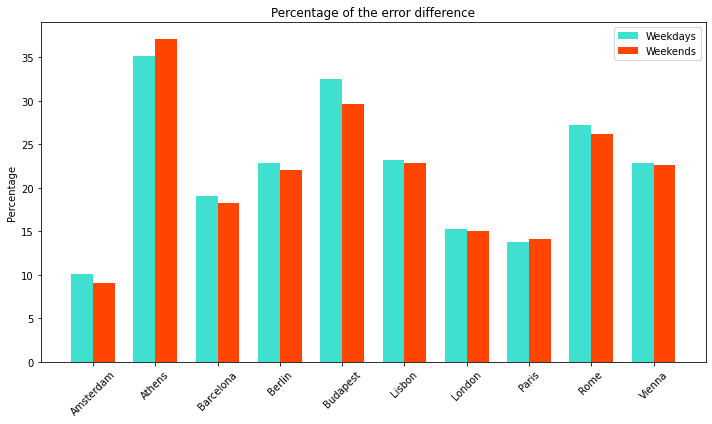

In [42]:
#Creat the dataset groupped by "city" and "type" attributes

grouped_city_type = data.groupby(['city', 'type'])

#Get average price per city and day type

avg_price_per_city_type = grouped_city_type['realSum'].mean()

avg_price_per_city_type = grouped_city_type['realSum'].mean()
 

# Percentage of error difference of the chosen model in relation to the average price

prev_city = None
for (city, type), value in avg_price_per_city_type.items():
   if city != prev_city:
       print(city)
       prev_city = city
       percentage = (54 / value) * 100
   print(' {}: {:.2f}%'.format(type, percentage))

#Visualisation of the error difference

import matplotlib.pyplot as plt
# Creating lists to store the city names, weekdays percentages, and weekends percentages
cities = []
weekdays_percentages = []
weekends_percentages = []

# Iterating over the avg_price_per_city_type dictionary
for (city, type), value in avg_price_per_city_type.items():
    if city not in cities:
        cities.append(city)
    
    percentage = (54.83 / value) * 100
    
    if type == 'Weekdays':
        weekdays_percentages.append(percentage)
    elif type == 'Weekends':
        weekends_percentages.append(percentage)

# Setting the width of each bar
bar_width = 0.35

# Creating the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Creating the x-axis positions
x = range(len(cities))

# Plotting the bars for weekdays
ax.bar(x, weekdays_percentages, bar_width, label='Weekdays', color='turquoise')

# Plotting the bars for weekends
ax.bar([i + bar_width for i in x], weekends_percentages, bar_width, label='Weekends', color='orangered')

# Setting the x-axis tick labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(cities, rotation=45)

# Setting the y-axis label and title
ax.set_ylabel('Percentage')
ax.set_title('Percentage of the error difference')

# Creating the legend
ax.legend()

plt.tight_layout()
plt.show()